
Lorenz system: σ=30.0, β=3.0, r=25.0
Lyapunov exponents (approx.):
λ1 = -0.51516
λ2 = -0.51519
λ3 = -32.96941
Sum: -33.99976680363385


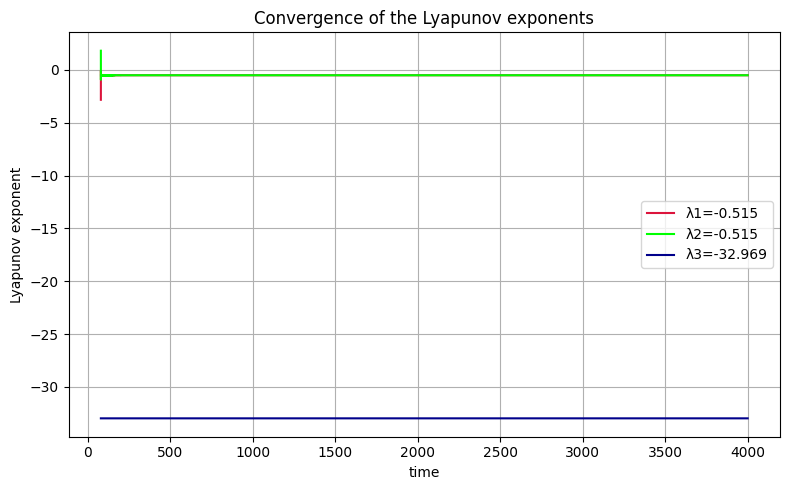

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ----- Parameter -----
sigma = 30.0
beta = 3.0
r = 25.0

dt = 0.005
total_time = 4000.0
orthonorm_interval = 0.03
transient = 80.0
x0 = np.array([1.0, 1.0, 1.0])

# ----- Lorenz-System & Jacobian -----
def lorenz(x):
    return np.array([
        sigma * (x[1] - x[0]),
        x[0]*(r - x[2]) - x[1],
        x[0]*x[1] - beta*x[2]
    ])

def jacobian(x):
    return np.array([
        [-sigma, sigma, 0],
        [r - x[2], -1, -x[0]],
        [x[1], x[0], -beta]
    ])

# ----- RK4 Integrator -----
def rk4_step(x, dt):
    k1 = lorenz(x)
    k2 = lorenz(x + 0.5*dt*k1)
    k3 = lorenz(x + 0.5*dt*k2)
    k4 = lorenz(x + dt*k3)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def rk4_variation(x, V, dt):
    J1 = jacobian(x)
    k1 = J1.dot(V)

    x2 = x + 0.5*dt*lorenz(x)
    J2 = jacobian(x2)
    k2 = J2.dot(V + 0.5*dt*k1)

    x3 = x + 0.5*dt*lorenz(x2)
    J3 = jacobian(x3)
    k3 = J3.dot(V + 0.5*dt*k2)

    x4 = x + dt*lorenz(x3)
    J4 = jacobian(x4)
    k4 = J4.dot(V + dt*k3)

    return V + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# ----- Integration Setup -----
n_steps = int(total_time / dt)
steps_per_orth = int(round(orthonorm_interval / dt))

x = x0.copy()
V = np.eye(3)
eps = 1e-12
sums = np.zeros(3)
count = 0

traj = []
times = []
t = 0.0
lyap_running = []

for step in range(n_steps):
    x = rk4_step(x, dt)
    V = rk4_variation(x, V, dt)
    t += dt

    if step % steps_per_orth == 0:
        Q, R = np.linalg.qr(V)
        d = np.diag(R)
        if any (np.abs(d)) < eps:
            d = eps
        signs = np.sign(d)
        signs[signs == 0] = 1
        Q *= signs
        R = (R.T * signs).T

        logs = np.log(np.abs(np.diag(R)) + eps)

        if t > transient:
            sums += logs
            count += 1
            lyap_running.append(sums / (count * orthonorm_interval))

        V = Q.copy()

    if step % int(1.0/dt) == 0:  # store 1Hz trajectory
        traj.append(x.copy())
        times.append(t)

# ----- Results -----
lyap = sums / (count * orthonorm_interval)
lyap_sorted = np.sort(lyap)[::-1]

print(f"\nLorenz system: σ={sigma}, β={beta}, r={r}")
print("Lyapunov exponents (approx.):")
for i, l in enumerate(lyap_sorted):
    print(f"λ{i+1} = {l:.5f}")
print("Sum:", np.sum(lyap_sorted))



if len(lyap_running) > 10:
    L = np.array(lyap_running)
    plt.figure(figsize=(8,5))
    plt.plot(np.linspace(transient, total_time, len(L)), L[:,0], label=f'λ1={round(lyap_sorted[0],3)}', color='crimson')
    plt.plot(np.linspace(transient, total_time, len(L)), L[:,1], label=f'λ2={round(lyap_sorted[1],3)}', color='lime')
    plt.plot(np.linspace(transient, total_time, len(L)), L[:,2], label=f'λ3={round(lyap_sorted[2],3)}',color='darkblue')
    plt.xlabel("time"); plt.ylabel("Lyapunov exponent")
    plt.title("Convergence of the Lyapunov exponents")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig('convergence.png', dpi=300)
    plt.show()

